## The Big Six - xG Rolling Charts

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patheffects as path_effects
import matplotlib.font_manager as fm
import matplotlib.colors as mcolors
from matplotlib import cm
from highlight_text import fig_text, ax_text
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib import cm
import matplotlib.gridspec as gridspec
import numpy as np

from PIL import Image
import urllib
import json
import os

In [3]:
font_path = "../assets/fonts"
for x in os.listdir(font_path):
    for y in os.listdir(f"{font_path}/{x}"):
        if y.split(".")[-1] == "ttf":
            fm.fontManager.addfont(f"{font_path}/{x}/{y}")
            try:
                fm.FontProperties(weight=y.split("-")[-1].split(".")[0].lower(), fname=y.split("-")[0])
            except Exception:
                continue

plt.style.use("../assets/stylesheets/soc_base.mplstyle")

### Define the color maps

Here we'll define a function that takes two colors and creates a gradient. I extracted the core code from the following [StackOverflow question](https://stackoverflow.com/questions/25668828/how-to-create-colour-gradient-in-python).

In [13]:
big_six_cm = {
    '8456': {
        'low': '#00285e',
        'high': '#97c1e7'
    },
    '8650': {
        'low': '#00B2A9',
        'high': '#C8102E'
    },
    '8455': {
        'low': '#d1d3d4',
        'high': '#034694'
    },
    '8586': {
        'low': '#0e9ca5',
        'high': '#132257'
    },
    '9825': {
        'low':'#063672',
        'high':'#db0007'
    },
    '10260':{
        'low':'#DBA111',
        'high':'#da020e'
    },
    '8654':{
        'low':'#2dafe5',
        'high':'#7c2c3b'
    },
    '8197':{
        'low':'#fdbe11',
        'high':'#0053a0'
    },
    '10204':{
        'low':'#d1d3d4',
        'high':'#005daa'
    },
    '8602':{
        'low':'#d1d3d4',
        'high':'#005daa'
    },
    '10261':{
        'low':'#d1d3d4',
        'high':'#005daa'
    },
    '9826':{
        'low':'#d1d3d4',
        'high':'#005daa'
    },
    '10252':{
        'low':'#d1d3d4',
        'high':'#005daa'
    },
    '8466':{
        'low':'#d1d3d4',
        'high':'#005daa'
    },
    '8668':{
        'low':'#d1d3d4',
        'high':'#005daa'
    },
}

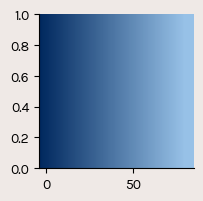

In [5]:
def colorFader(c1,c2,mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    c1=np.array(mcolors.to_rgb(c1))
    c2=np.array(mcolors.to_rgb(c2))
    return mcolors.to_hex((1-mix)*c1 + mix*c2)

# Example with Liverpool
c1=big_six_cm['8456']['low']
c2=big_six_cm['8456']['high']
n=83

fig, ax = plt.subplots(figsize=(2, 2))
for x in range(n+1):
    ax.axvline(x, color=colorFader(c1,c2,x/n), linewidth=10) 
plt.show()

### Reading the data

I have supplied a CSV file with xG figures for all EPL teams since the beginning of the 2020/2021 season. Feel free to use it for other purposes...

In [6]:
df = pd.read_csv('data/09262022_epl_xg.csv', index_col=0)
df = df.sort_values(by='date').reset_index(drop=True)
df.head()

,match_id,date,referee,variable,value,venue,team_id,team_name,team_lineup
0,3411352,2020-09-12 06:30:00,Chris Kavanagh,score_for,0.00,H,9879,Fulham,4 - 2 - 3 - 1
1,3411352,2020-09-12 06:30:00,Chris Kavanagh,score_ag,0.00,A,9825,Arsenal,3 - 4 - 3
2,3411352,2020-09-12 06:30:00,Chris Kavanagh,xG_ag,0.15,A,9825,Arsenal,3 - 4 - 3
3,3411352,2020-09-12 06:30:00,Chris Kavanagh,xG_for,1.97,A,9825,Arsenal,3 - 4 - 3
4,3411352,2020-09-12 06:30:00,Chris Kavanagh,score_for,3.00,A,9825,Arsenal,3 - 4 - 3


### Function to create xG rolling data

In [7]:
def get_xG_rolling_data(team_id, window=10, data=df):
    '''
    This function returns xG rolling average figures for a specific team.
    '''
    df = data.copy()
    df_xg = df[(df['team_id'] == team_id) & (df['variable'].isin(['xG_for', 'xG_ag']))]
    df_xg = (
        df_xg.pivot(
            index=['date', 'match_id', 'team_id', 'team_name'],
            columns=['variable'],
            values=['value']
        ).reset_index()
        .droplevel(level=0, axis=1)
    )
    df_xg.columns = ['date', 'match_id', 'team_id', 'team_name', 'xG_ag', 'xG_for']
    df_xg['rolling_xG_for'] = df_xg['xG_for'].rolling(window=window, min_periods=0).mean()
    df_xg['rolling_xG_ag'] = df_xg['xG_ag'].rolling(window=window, min_periods=0).mean()
    df_xg['rolling_diff'] = df_xg['rolling_xG_for'] - df_xg['rolling_xG_ag']
    return df_xg

In [8]:
get_xG_rolling_data(10260)

,date,match_id,team_id,team_name,xG_ag,xG_for,rolling_xG_for,rolling_xG_ag,rolling_diff
0,2020-09-19 11:30:00,3411365,10260,Manchester United,1.66,1.23,1.230000,1.660000,-0.4300
1,2020-09-26 06:30:00,3411369,10260,Manchester United,2.55,1.55,1.390000,2.105000,-0.7150
2,2020-10-04 10:30:00,3411385,10260,Manchester United,3.51,0.95,1.243333,2.573333,-1.3300
3,2020-10-17 14:00:00,3411395,10260,Manchester United,0.85,2.29,1.505000,2.142500,-0.6375
4,2020-10-24 11:30:00,3411405,10260,Manchester United,0.22,0.66,1.336000,1.758000,-0.4220
...,...,...,...,...,...,...,...,...,...
77,2022-08-13 11:30:00,3900944,10260,Manchester United,1.61,0.92,1.271000,1.690000,-0.4190
78,2022-08-22 14:00:00,3900958,10260,Manchester United,1.35,1.79,1.334000,1.770000,-0.4360
79,2022-08-27 06:30:00,3900970,10260,Manchester United,1.45,1.40,1.248000,1.717000,-0.4690
80,2022-09-01 14:00:00,3900976,10260,Manchester United,0.73,1.55,1.392000,1.568000,-0.1760


### Function to create auxiliary xG dataframe

In order to create gradients, we need to extend our dataframe and interpolate values

In [9]:
def get_xG_interpolated_df(team_id, window=10, data=df):
    # --- Get the xG rolling df
    df_xG = get_xG_rolling_data(team_id, window, data)
    # -- Create interpolated series
    df_xG['match_number'] = df_xG.index
    X_aux = df_xG.match_number.copy()
    X_aux.index = X_aux * 10 # 9 aux points in between each match
    last_idx = X_aux.index[-1] + 1
    X_aux = X_aux.reindex(range(last_idx))
    X_aux = X_aux.interpolate()
    # --- Aux series for the xG created (Y_for)
    Y_for_aux = df_xG.rolling_xG_for.copy()
    Y_for_aux.index = Y_for_aux.index * 10
    last_idx = Y_for_aux.index[-1] + 1
    Y_for_aux = Y_for_aux.reindex(range(last_idx))
    Y_for_aux = Y_for_aux.interpolate()
    # --- Aux series for the xG conceded (Y_ag)
    Y_ag_aux = df_xG.rolling_xG_ag.copy()
    Y_ag_aux.index = Y_ag_aux.index * 10
    last_idx = Y_ag_aux.index[-1] + 1
    Y_ag_aux = Y_ag_aux.reindex(range(last_idx))
    Y_ag_aux = Y_ag_aux.interpolate()
    # --- Aux series for the rolling difference in xG
    Z_diff_aux = df_xG.rolling_diff.copy()
    Z_diff_aux.index = Z_diff_aux.index * 10
    last_idx = Z_diff_aux.index[-1] + 1
    Z_diff_aux = Z_diff_aux.reindex(range(last_idx))
    Z_diff_aux = Z_diff_aux.interpolate()
    # -- Create the aux dataframe
    df_aux = pd.DataFrame({
        'X': X_aux,
        'Y_for': Y_for_aux,
        'Y_ag': Y_ag_aux,
        'Z': Z_diff_aux
    })
    return df_aux

In [40]:
get_xG_interpolated_df(10260)

,X,Y_for,Y_ag,Z
0,0.0,1.2300,1.6600,-0.4300
1,0.1,1.2460,1.7045,-0.4585
2,0.2,1.2620,1.7490,-0.4870
3,0.3,1.2780,1.7935,-0.5155
4,0.4,1.2940,1.8380,-0.5440
...,...,...,...,...
806,80.6,1.3572,1.4798,-0.1226
807,80.7,1.3514,1.4651,-0.1137
808,80.8,1.3456,1.4504,-0.1048
809,80.9,1.3398,1.4357,-0.0959


### Function to plot the xG rolling chart

In [16]:
def plot_xG_gradient(ax, team_id, window=10, data=df):
    # -- Get the data
    df_xg = get_xG_rolling_data(team_id, window, data)
    df_aux_xg = get_xG_interpolated_df(team_id, window, data)
    # Specify the axes limits
    ax.set_ylim(0,3)
    ax.set_xlim(-0.5,df_xg.shape[0])
    ax.grid(ls='--', color='lightgrey')
    # -- Select the colors
    color_2 = '#00ff85'
    color_1 = '#38003c'

    ax.plot(df_xg.index, df_xg['rolling_xG_for'], color=color_2,zorder=4)
    ax.plot(df_xg.index, df_xg['rolling_xG_ag'], color=color_1,zorder=4)
    ax.fill_between(x=[-0.5,window], y1=ax.get_ylim()[0], y2=ax.get_ylim()[1], alpha=0.15, color='black', ec='None',zorder=2)
    vmin = df_xg['rolling_diff'].min()
    vmax = df_xg['rolling_diff'].max()
    vmax = max(abs(vmin), abs(vmax))
    vmin = -1*vmax
    for i in range(0, len(df_aux_xg['X']) - 1):
        ax.fill_between(
            [df_aux_xg['X'].iloc[i], df_aux_xg['X'].iloc[i+1]],
            [df_aux_xg['Y_for'].iloc[i], df_aux_xg['Y_for'].iloc[i + 1]],
            [df_aux_xg['Y_ag'].iloc[i], df_aux_xg['Y_ag'].iloc[i + 1]],
            color=colorFader(color_1, color_2, mix=((df_aux_xg['Z'].iloc[i] - vmin)/(vmax - vmin))),
            zorder=3, alpha=0.3
        )
    for x in [38, 38*2]:
        ax.plot([x,x],[ax.get_ylim()[0], ax.get_ylim()[1]], color='black', alpha=0.35, zorder=2, ls='dashdot', lw=0.95)

    for x in [22, 60]:
        if x == 22:
            text = '20/21 season'
        else:
            text = '21/22 season'
        text_ = ax.annotate(
            xy=(x,2.75),
            text=text,
            color='black',
            size=7,
            va='center',
            ha='center',
            weight='bold',
            zorder=4
        )
        text_.set_path_effects(
            [path_effects.Stroke(linewidth=1.5, foreground='white'), path_effects.Normal()]
        )
    return ax

<AxesSubplot:>

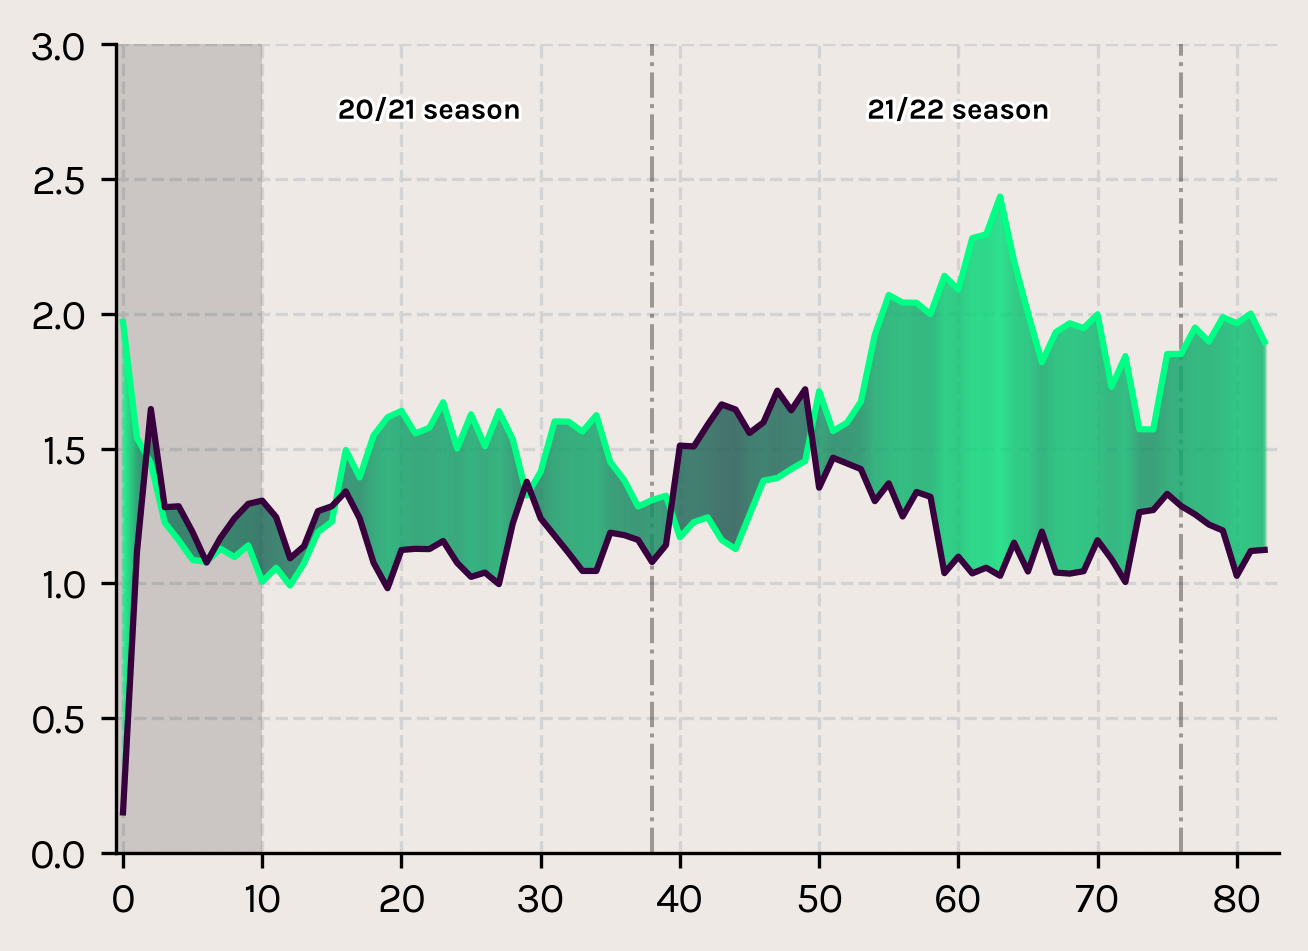

In [17]:
fig = plt.figure(figsize=(5,3.5), dpi=300)
ax = plt.subplot(111)

plot_xG_gradient(ax, 9825, 10)

### The Final Viz

In [71]:
list(big_six_cm.keys())

['8456', '8650', '8455', '8586', '9825', '10260']

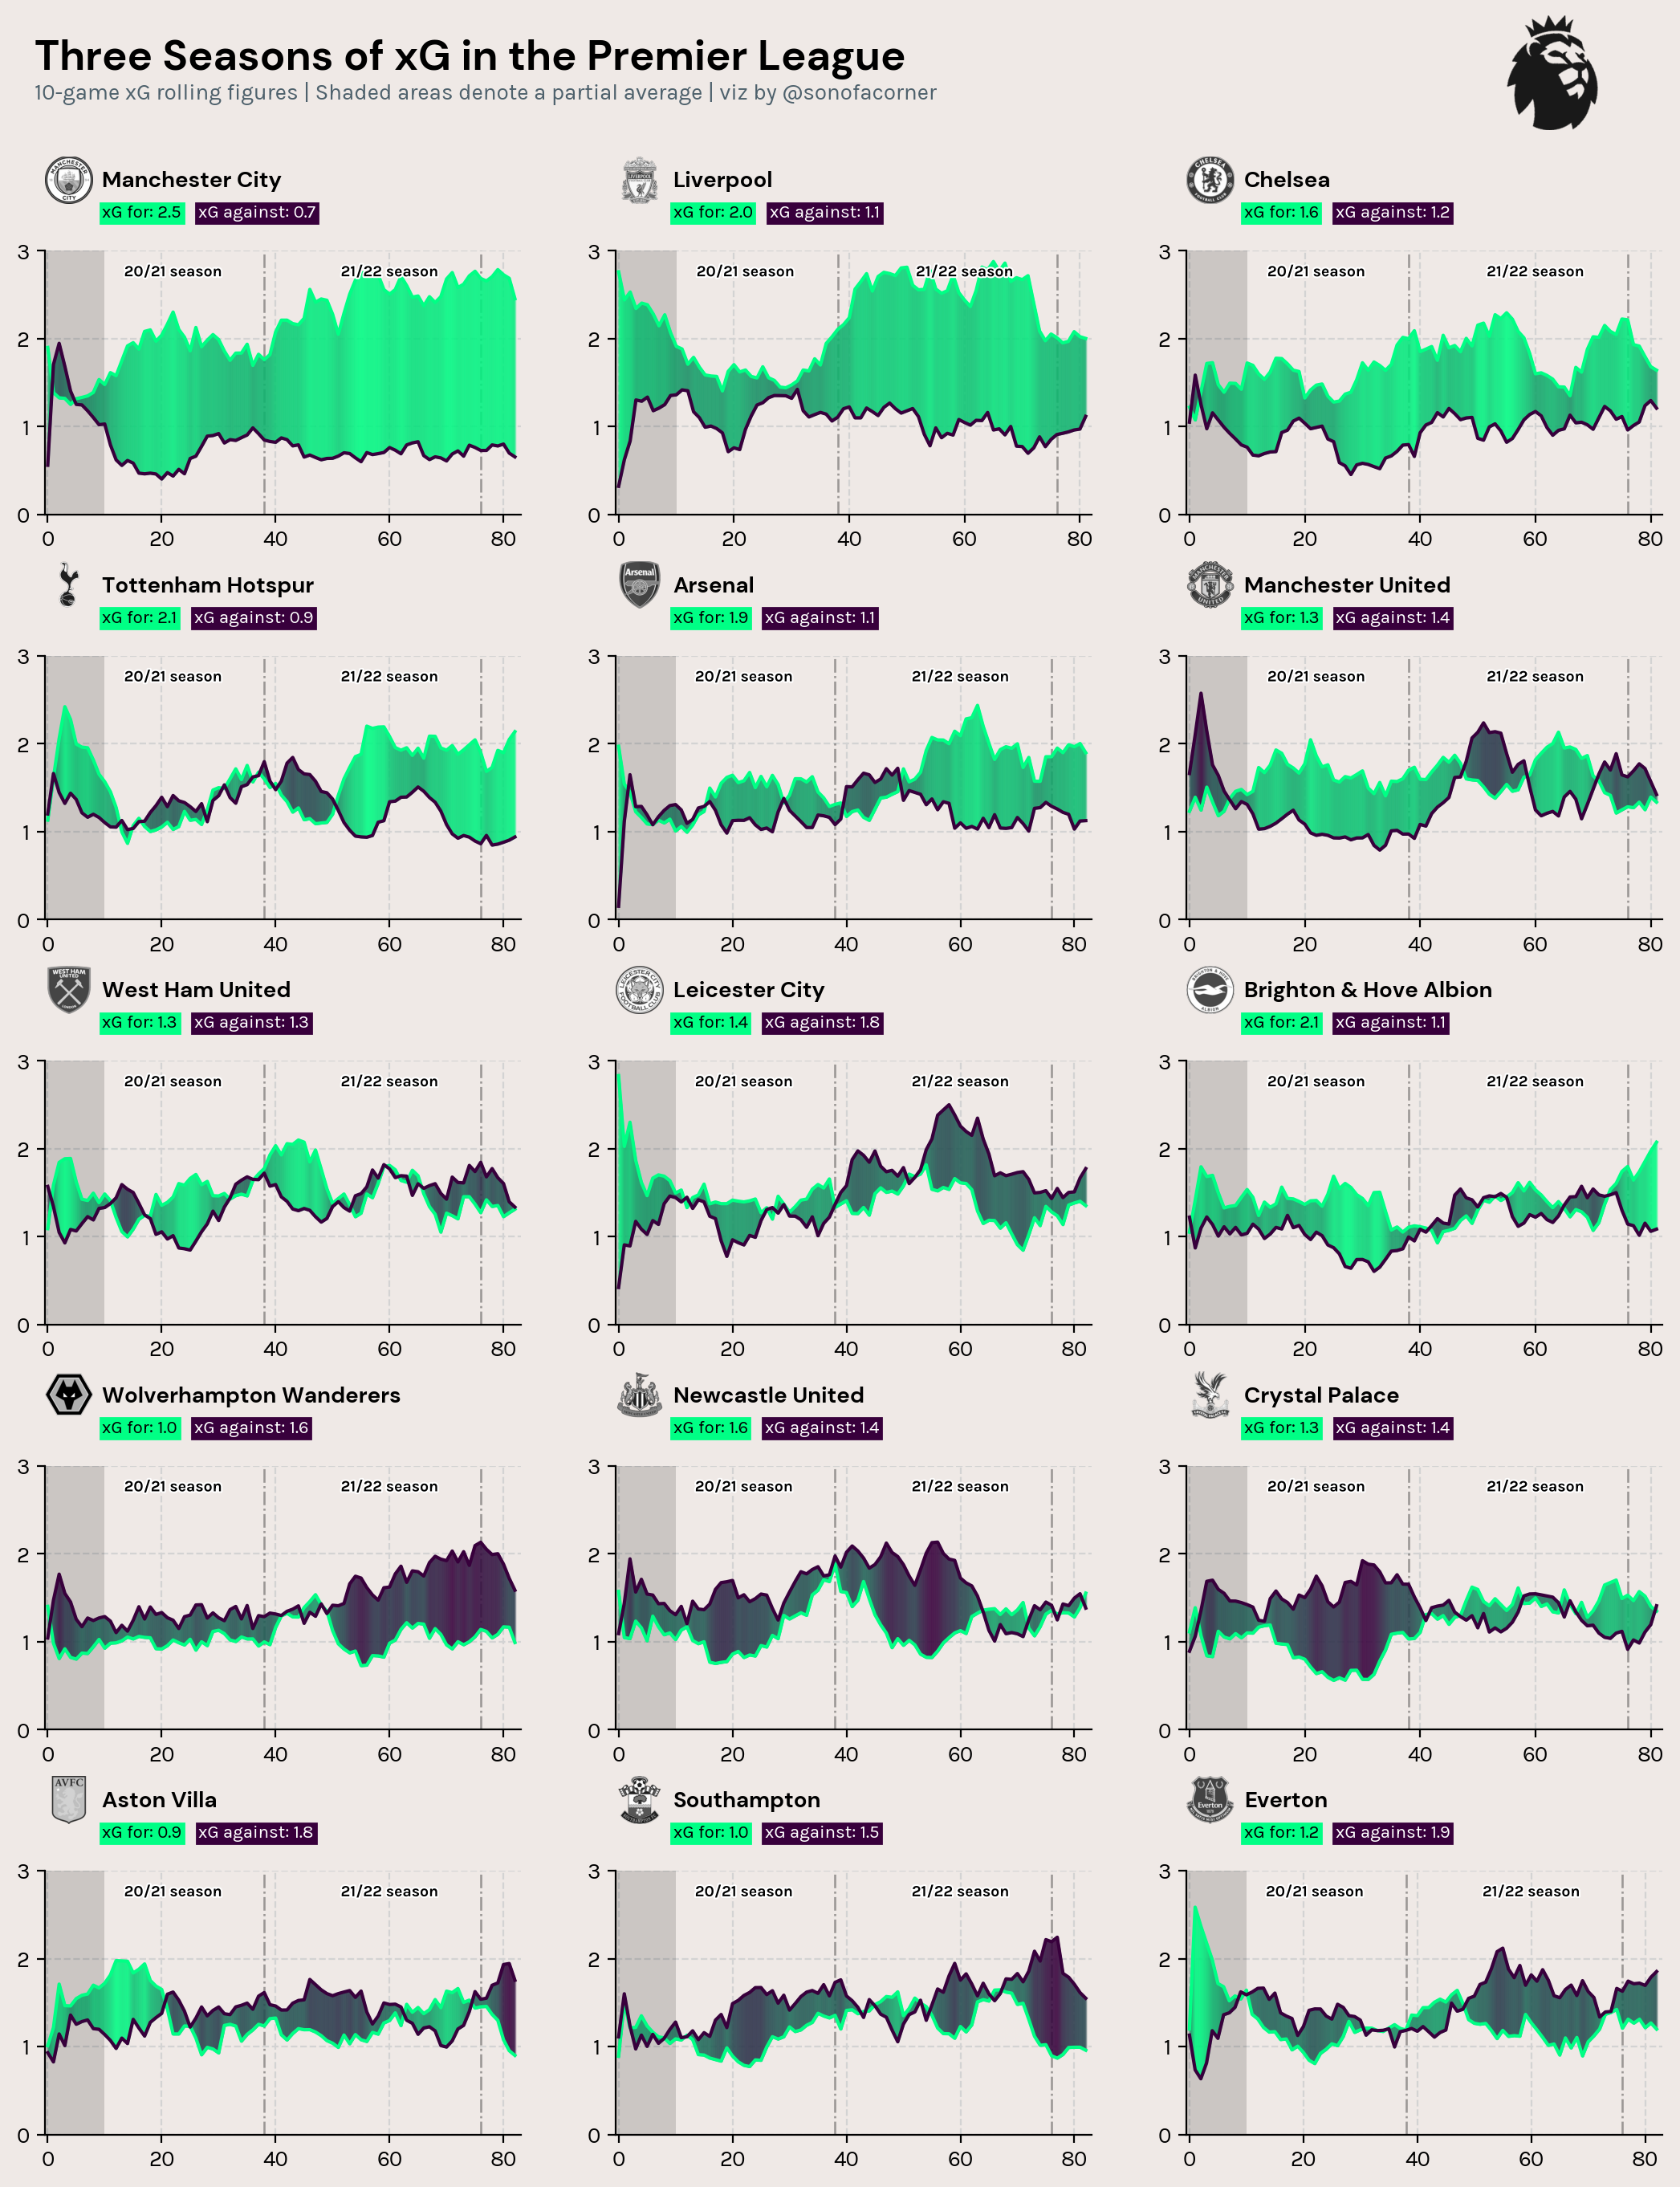

In [18]:
# ---- for path effects
def path_effect_stroke(**kwargs):
    return [path_effects.Stroke(**kwargs), path_effects.Normal()]
pe = path_effect_stroke(linewidth=1.5, foreground="black")
# ----
fig = plt.figure(figsize=(13, 16), dpi = 200)
nrows = 10
ncols = 3
gspec = gridspec.GridSpec(
    ncols=ncols, nrows=nrows, figure=fig, 
    height_ratios=[(1/nrows)*2.35 if x % 2 != 0 else (1/nrows)/2.35 for x in range(nrows)], hspace=0.3
)

plot_counter = 0
logo_counter = 0

for row in range(nrows):
    for col in range(ncols):
        if row % 2 != 0:
            ax = plt.subplot(
                gspec[row, col],
                facecolor = "#EFE9E6"
            )
            teamId = list(big_six_cm.keys())[plot_counter]
            teamId = int(teamId)
            plot_xG_gradient(ax, teamId, 10)           
            plot_counter += 1
        else:
            teamId = list(big_six_cm.keys())[logo_counter]
            color_2 = '#00ff85'
            color_1 = '#38003c'
            # -- This was done manually cuz I'm lazy...
            # if color_1 == '#d1d3d4':
            color_2_t = 'black'
            # else:
            color_1_t = 'white'
            # if color_2 == '#97c1e7':
            #     color_2_t = 'black'
            # else:
            #     color_2_t = 'white'
            teamId = int(teamId)
            df_for_text = get_xG_rolling_data(teamId, 10)
            teamName = df_for_text['team_name'].iloc[0]
            xG_for = df_for_text['rolling_xG_for'].iloc[-1]
            xG_ag = df_for_text['rolling_xG_ag'].iloc[-1]
            fotmob_url = 'https://images.fotmob.com/image_resources/logo/teamlogo/'
            logo_ax = plt.subplot(
                gspec[row,col],
                anchor = 'NW', facecolor = '#EFE9E6'
            )
            club_icon = Image.open(urllib.request.urlopen(f'{fotmob_url}{teamId:.0f}.png')).convert('LA')
            logo_ax.imshow(club_icon)
            logo_ax.axis('off')
            # -- Add the team name
            ax_text(
                x = 1.2, 
                y = 0.7,
                s = f'<{teamName}>\n<xG for: {xG_for:.1f}> <|> <xG against: {xG_ag:.1f}>',
                ax = logo_ax, 
                highlight_textprops=[
                    {'weight':'bold', 'font':'DM Sans'},
                    {'size':'8', 'bbox': {'edgecolor': color_2, 'facecolor': color_2, 'pad': 1}, 'color': color_2_t}, 
                    {'color':'#EFE9E6'},
                    {'size':'8', 'bbox': {'edgecolor': color_1, 'facecolor': color_1, 'pad': 1}, 'color': color_1_t}
                ],
                font = 'Karla', 
                ha = 'left', 
                size = 10, 
                annotationbbox_kw = {'xycoords':'axes fraction'}
            )
            logo_counter += 1

fig_text(
    x=0.12, y=.91, 
    s='Three Seasons of xG in the Premier League',
    va='bottom', ha='left',
    fontsize=19, color='black', font='DM Sans', weight='bold'
)
fig_text(
	x=0.12, y=.9, 
    s='10-game xG rolling figures | Shaded areas denote a partial average | viz by @sonofacorner',
	va='bottom', ha='left',
	fontsize=10, color='#4E616C', font='Karla'
)
fotmob_url = 'https://images.fotmob.com/image_resources/logo/leaguelogo/'
logo_ax = fig.add_axes(
    [.82, .885, .055, .055]
)
club_icon = Image.open(urllib.request.urlopen(f'{fotmob_url}{47:.0f}.png')).convert('LA')
logo_ax.imshow(club_icon)
logo_ax.axis('off')

plt.savefig(
	"figures/09262022_epl_xG_rolling_gradient_variant2.png",
	dpi = 600,
	facecolor = "#EFE9E6",
	bbox_inches="tight",
    edgecolor="none",
	transparent = False
)

# plt.savefig(
# 	"figures/09262022_epl_xG_rolling_gradient_tr.png",
# 	dpi = 600,
# 	facecolor = "none",
# 	bbox_inches="tight",
#     edgecolor="none",
# 	transparent = True
# )